In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import brownian_motion as bm 
from scipy.stats import jarque_bera
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
import seaborn as sns

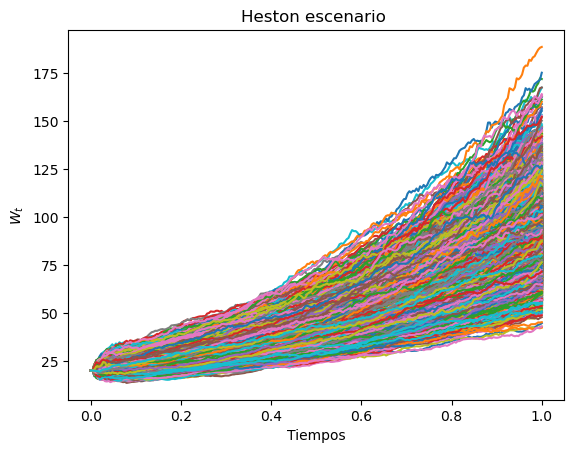

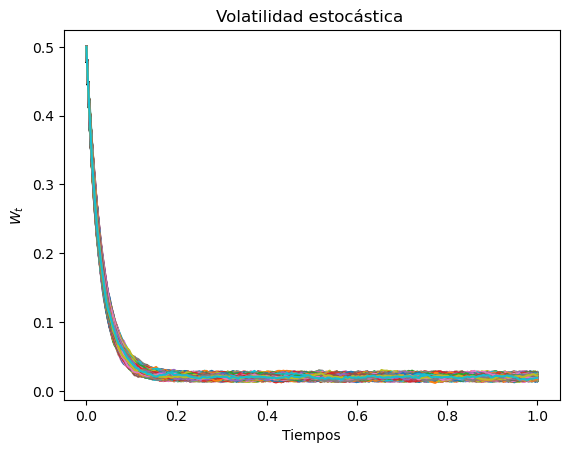

In [154]:
N = norm.cdf
kappa =4
theta = 0.02
v_0 =  0.02
xi = 0.9
r = 0.02
S = 100
paths =50000
steps = 2000
T = 1





def get_Heston_matr(S0:float, v0:float , n: int, d: int, mu:float, alpha:float, theta:float, sigma:float, rho:float, dt:float=1):
    """Retornar d trayectorias de tamaño n de Movimiento browniano geométrico con volatilidad estocástica
    Recibe: 
    
    Retorna:
    S: matriz de trayectorias de precios
    V: matriz de trayectorias de volatilidades. Cada fila de V es la volatilidad de la fila correspondiente en S
    """
    if v0<0:
        raise Exception("Condiciones iniciales de volatilidad negativas")
    S=np.zeros((d,n)) ####Cambiar por n,d
    v=np.zeros((d,n))
    #Condiciones iniciales
    S[:,0]=S0*np.ones(d) #Cambiar por S[0,:]=S0*np.ones(d)
    v[:,0]=v0*np.ones(d)

    #Simulación de matrices de incrementos correlacionados
    B1,B_=bm.get_B_matrix(n-1,d,dt=dt),bm.get_B_matrix(n-1,d,dt=dt)#Brownianos indep
    B2=rho*B1+np.sqrt(1-rho**2)*B_# fila i de B1 correlacionada con fila i de B2
    dB1=bm.dif_B(B1)# Devuelve el vector de incrementos agregando 0 al inicio para tener igual longitud
    dB2=bm.dif_B(B2)
    
    for i in range (1,n):
        S[:,i]=S[:,i-1]*np.exp((mu-(1/2)*np.abs(v[:,i-1]))*dt+np.sqrt(np.abs(v[:,i-1]))*dB1[:,i-1])
        #print(v[:,i-1])
        v[:,i]=v[:,i-1]+alpha*(theta-np.abs(v[:,i-1]))*dt+sigma*np.sqrt(np.abs(v[:,i-1]))*dB2[:,i-1]
        #v[:,i]=
    return S,v

S0=20
v0=0.5
n=252
d=10000
mu=1.5
alpha=30
theta=0.02
sigma=0.1
rho=0.1
dt=T/n
t=np.linspace(0,T,n+1)
S,V=get_Heston_matr(S0,v0,n+1,d,mu,alpha,theta,sigma,rho,dt=dt)


fig, ax = plt.subplots()
ax.plot(t,S.T)
ax.set_title("Heston escenario ")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show()

fig, ax = plt.subplots()
ax.plot(t,V.T)
ax.set_title("Volatilidad estocástica ")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show()

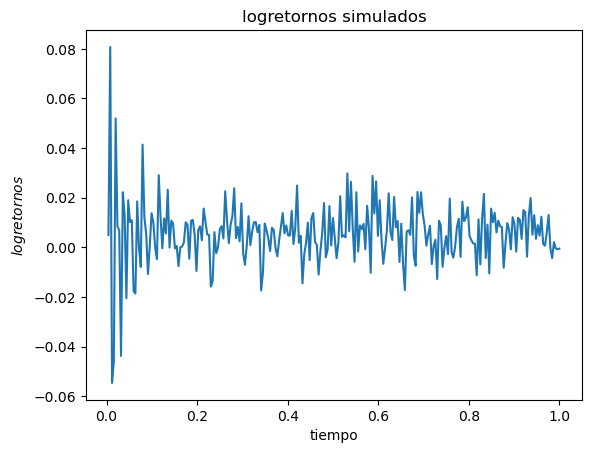

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 10000.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.]),
 array([-0.5       , -0.46666667, -0.43333333, -0.4       , -0.36666667,
        -0.33333333, -0.3       , -0.26666667, -0.23333333, -0.2       ,
        -0.16666667, -0.13333333, -0.1       , -0.06666667, -0.03333333,
         0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
         0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
         0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
         0.5       ]),
 <BarContainer object of 30 artists>)

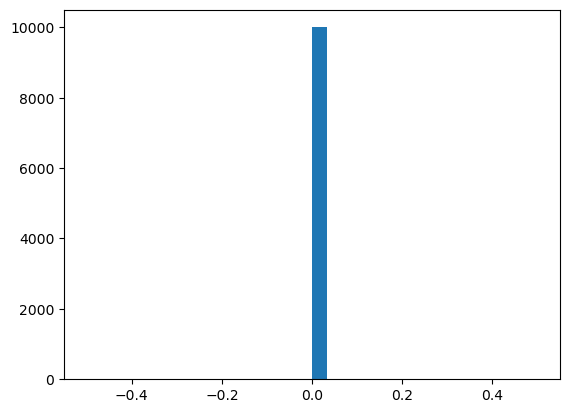

In [158]:
log_retG=np.diff(np.log(S),axis=1)

fig, ax = plt.subplots()
ax.plot(t[1:],log_retG[1].T)
ax.set_title("logretornos simulados")
ax.set_xlabel("tiempo")
ax.set_ylabel("$log retornos$")
plt.show() 
#sm.qqplot(perc_retG[10],line="45")
test=[]
for i in range(d):
    test.append(jarque_bera(V[i]).pvalue)
plt.hist(test,bins=30)

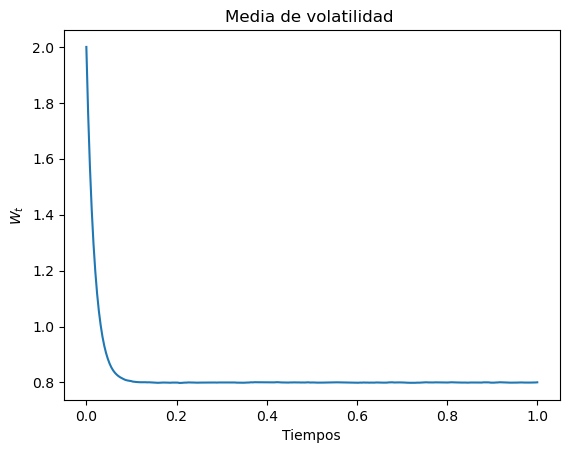

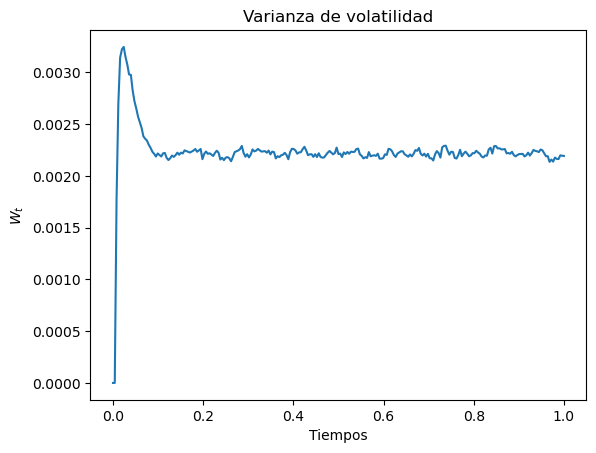

In [144]:
fig, ax = plt.subplots()
ax.plot(t,np.mean(V,axis=0).T)
ax.set_title("Media de volatilidad ")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show()

fig, ax = plt.subplots()
ax.plot(t,np.var(V,axis=0).T)
ax.set_title("Varianza de volatilidad")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show()

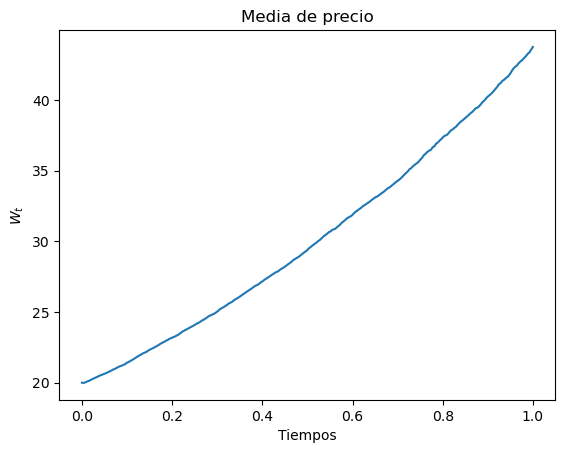

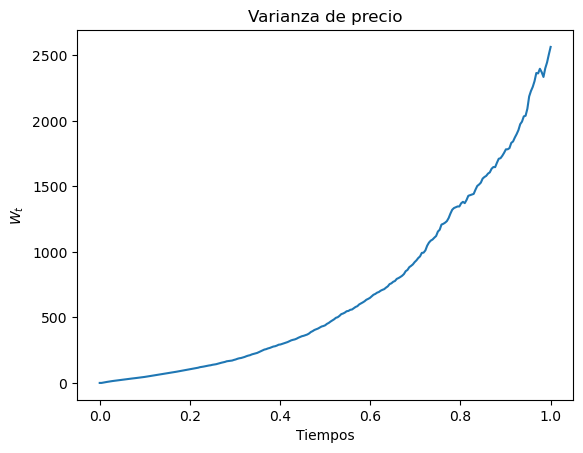

In [145]:
fig, ax = plt.subplots()
ax.plot(t,np.mean(S,axis=0).T)
ax.set_title("Media de precio")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show()

fig, ax = plt.subplots()
ax.plot(t,np.var(S,axis=0).T)
ax.set_title("Varianza de precio")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show()

0


Text(0, 0.5, 'Density')

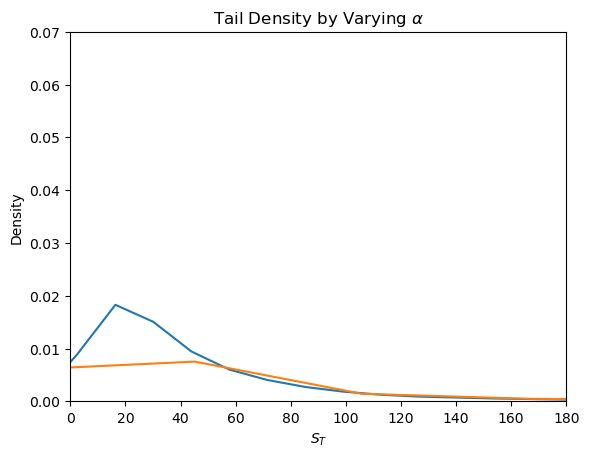

In [151]:
#Estimación densidad para valores de correlación 
fig, ax = plt.subplots()

sim_corr1,_=get_Heston_matr(S0,v0,n,d,mu,alpha,theta,sigma,rho,dt=dt)
sim_corr2,_=get_Heston_matr(S0,v0,n,d,mu,alpha/100,theta,sigma,rho,dt=dt)
GMB=bm.EM_geom_brown(S0,mu,v0,n,d,dt=dt)[:,-1] #El parámetro de sigma lo tomo como la volatilidad inicial
print(np.sum(sim_corr2[:,-1]<0))
ax = sns.kdeplot(data=sim_corr1[:,-1], label="$\rho = 0.9$", ax=ax)
ax = sns.kdeplot(data=sim_corr2[:,-1], label="$\rho= -0.9$ ", ax=ax)
#ax = sns.kdeplot(data=GMB, label="GBM", ax=ax)

ax.set_title(r'Tail Density by Varying $\alpha$')
plt.axis([0, 180, 0, 0.07])
plt.xlabel('$S_T$')
plt.ylabel('Density')

In [153]:
def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0


# Create a Gometric Brownian Motion, Mean-Reverting and Trending Series
# gbm = np.log(np.cumsum(np.random.randn(100000))+1000)
# mr = np.log(np.random.randn(100000)+1000)
# tr = np.log(np.cumsum(np.random.randn(100000)+1)+1000)
# print(tr)
# Output the Hurst Exponent for each of the above series
# and the price of Google (the Adjusted Close price) for 
# the ADF test given above in the article
# print("Hurst(GBM):   %s" % hurst(gbm))
# print("Hurst(MR):    %s" % hurst(mr))
# print("Hurst(TR):    %s" % hurst(tr))

# # Assuming you have run the above code to obtain 'goog'!
# print("Hurst(GOOG):  %s" % hurst(goog['Adj Close'].values))
v_hurst=[]
for i in range(2000):
    v_hurst.append(hurst(S[i]))
print(np.mean(v_hurst))

0.34195423472623393


c:\Users\marti\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


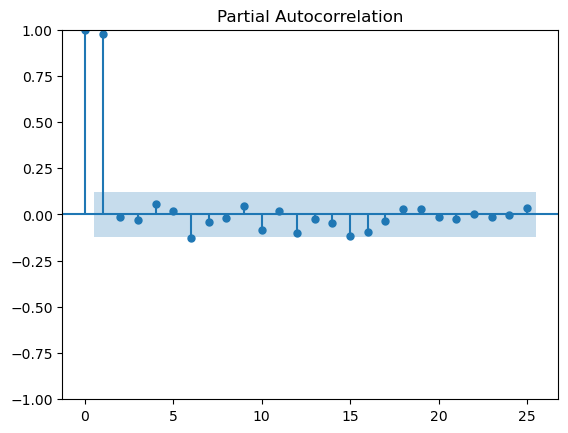

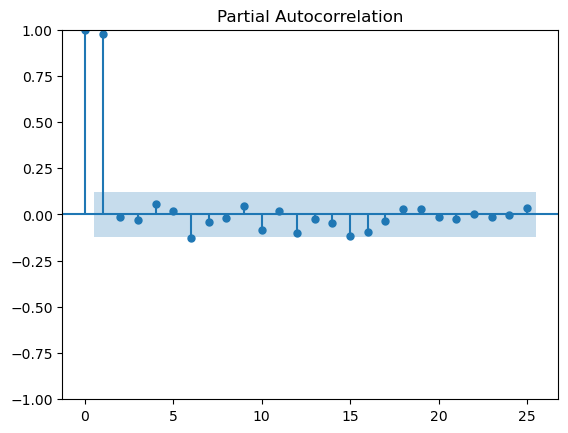

In [141]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(S[0,:])